<a href="https://colab.research.google.com/github/jomacuesta/ScriptsPython/blob/main/P2_Jose_Manuel_Cuesta_Ramirez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PRÁCTICA 2 - 07MBID - MACHINE LEARNING
####DengAI : Predicting Disease Spread [enlace](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

Usuario Dengue: jmcr_VIU - 25.63
[enlace](https://www.drivendata.org/users/jmcr_VIU/)

##OBJETIVO DE LA PRACTICA

Esta práctica se enmarca dentro de la asignatura de Machine Learning propia del Máster de Big Data y Data Science. 

En concreto, se corresponde con la segunda parte de un ejercicio práctico en el que se busca crear un modelo capaz de predecir en base a las situaciones climatológicas y las posiciones geográficas de la ciudad el número de casos de dengue. 

Durante la primera parte se realizaron numerosos estudios de correlación entre las variables así como estudios de clusterización dónde concluimos que a pesar de que el problema nos proporcionaba 2 regiones, internamente, podíamos decir que existía un mayor número de subregiones (3-5).

En esta parte realizaremos la creación de un modelo supervisado que será finalmente evaluado.



## ANALISIS BREVE DEL DENGUE - ¿CAUSA? ¿CONDICIONES DE PROLIFERACION?

El dengue posee mayor transmisión en climas tropicales donde abundan las lluvias, climas cálidos (25-28 grados) y humedad. 

En 2019, se aprobó Dengvaxia para evitar nuevos contagios en aquellas personas previamente contagiadas con 1 de los 3 tipos de dengue.

Al contrario que otro tipo de mosquitos, suele picar durante el dia.

## CARGA DE DATOS

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [ ]:
#Tomamos archivo
train_feat = pd.read_csv("/content/dengue_features_train.csv")

In [ ]:
train_feat.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
train_labels = pd.read_csv("/content/dengue_labels_train.csv")

In [ ]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Unimos los dos conjuntos de datos para tener un único dataframe.

In [ ]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Subimos también el conjunto de datos para test, para completar la fase de carga de datos.

In [ ]:
train.shape

(1456, 25)

In [ ]:
test = pd.read_csv("/content/dengue_features_test.csv")
test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [ ]:
test.shape

(416, 24)

In [ ]:
train_sj = train[train['city']=='sj']
train_iq = train[train['city']=='iq']
test_sj = test[test['city']=='sj']
test_iq = test[test['city']=='iq']

## INSPECCION GENERAL DE LA VARIABLE OBJETIVO

In [ ]:
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


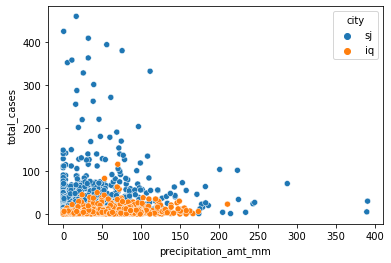

In [ ]:
sns.scatterplot(data=train, x="precipitation_amt_mm", y="total_cases",hue='city')

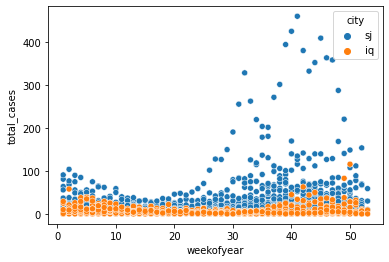

In [ ]:
sns.scatterplot(data=train, x="weekofyear", y="total_cases",hue='city')

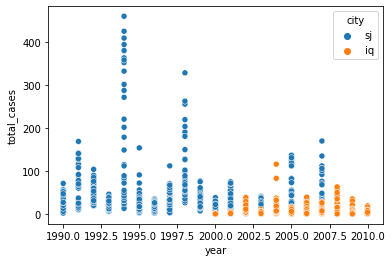

In [ ]:
sns.scatterplot(data=train, x="year", y="total_cases",hue='city')
#No existen datos de iq antes del 2000, por tanto el efecto temporal puede verse 
#afectado por los casos de sj o iq y no por el numero de casos como pretendemos.

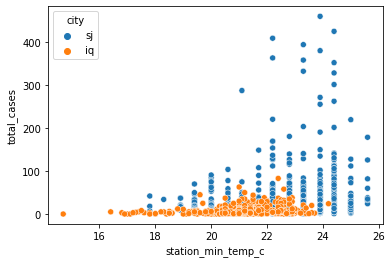

In [ ]:
sns.scatterplot(data=train, x="station_min_temp_c", y="total_cases",hue='city')

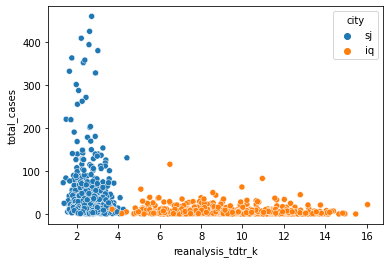

In [ ]:
sns.scatterplot(data=train, x="reanalysis_tdtr_k", y="total_cases",hue='city')

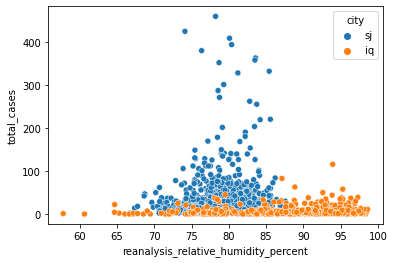

In [ ]:
sns.scatterplot(data=train, x="reanalysis_relative_humidity_percent", y="total_cases",hue='city')

De estos análisis, podemos concluir que no parece lo más correcto aplicar el mismo modelo para ambas ciudades. Por este motivo, vamos a dividir los datasets. En la mayoría de variables la ciudad de san juan se comporta con una tendencia creciente en forma de "campana" que no parece ser igual en iquitos y además los rangos de valores son distintos.

## PREPROCESADO

In [ ]:
train_iq.drop("week_start_date", axis = 1, inplace = True)
train_sj.drop("week_start_date", axis = 1, inplace = True)
test_iq.drop("week_start_date", axis = 1, inplace = True)
test_sj.drop("week_start_date", axis = 1, inplace = True)

Analizamos los valores nulos, que deben ser tratados para poder construir y evaluar nuestro modelo.

In [ ]:
pd.isnull(train_sj).sum()

city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_min_temp_c                         6
station_pr

In [ ]:
pd.isnull(train_iq).sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c                        8
station_precip_mm               

In [ ]:
#Empleamos la propación del valor hacia el siguiente valor nulo 
train_sj.fillna(method='ffill', inplace=True)
train_iq.fillna(method='ffill', inplace=True)

pd.isnull(train_sj).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

In [ ]:
#Empleamos el mismo método para test
test_sj.fillna(method='ffill', inplace=True)
test_iq.fillna(method='ffill', inplace=True)
pd.isnull(test_sj).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

Convertimos las variables categóricas a numéricas
En este caso, únicamente aplica para las ciudades.

In [ ]:
#TRAIN
train_iq_copy = train_iq
train_sj_copy = train_sj
train_iq.drop("city", axis = 1, inplace = True)
train_sj.drop("city", axis = 1, inplace = True)
#TEST
test_iq_copy = test_iq
test_sj_copy = test_sj
test_iq.drop("city", axis = 1, inplace = True)
test_sj.drop("city", axis = 1, inplace = True)

A continuación realizaremos un análisis de correlación.

Aunque en la práctica 1, realizamos este ejercicio, en esta ocasión podemos realizar el análisis comparando con la variable target.

Previo a la correlación realizaremos un análisis de Outliers que podría llevar a una elección errónea/menos acertada de las características para cada conjunto de datos ya que como se verá más adelante existen numerosas columnas con valores de correlación muy similares.

### Outliers

#### San Juan

Analizando la variable TIEMPO (Son climas tropicales con variaciones muy ligeras de temperatura, por tanto consideramos esta variable fundamental para el análisis de outliers)

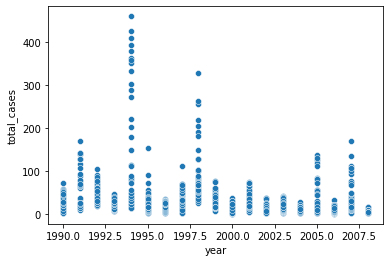

In [ ]:
sns.scatterplot(data=train_sj, x="year", y="total_cases")

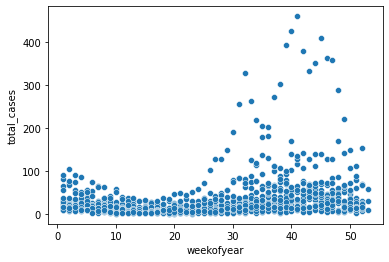

In [ ]:
sns.scatterplot(data=train_sj, x="weekofyear", y="total_cases")

Podemos observar como el mínimo de casos coincide con las semanas más calurosas del año. En San Juan las semanas de invierno son entre la 38 y 51, mientras que la más calurosa del año se localiza en la semana 13. (Parece contradictorio a la teoría)

Sin embargo, vamos a considerar outliers aquellos registros con más de 210 casos, porque no siguen un patrón y parece que se localizaron principalmente en ciertas semanas seguidas de un año específico.

In [ ]:
train_sj = train_sj[train_sj['total_cases']< 210]

In [ ]:
train_sj.shape

(919, 23)

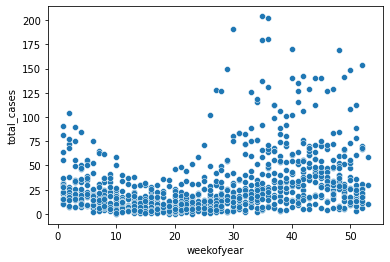

In [ ]:
sns.scatterplot(data=train_sj, x="weekofyear", y="total_cases")

#### Iquitos

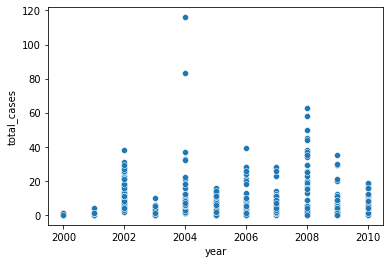

In [ ]:
sns.scatterplot(data=train_iq, x="year", y="total_cases")

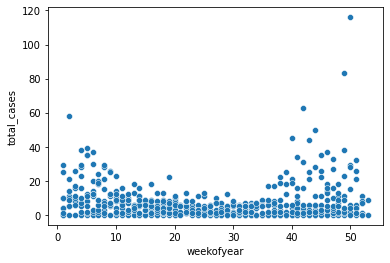

In [ ]:
sns.scatterplot(data=train_iq, x="weekofyear", y="total_cases")

En iquitos sin embargo si observamos lo esperado, respetando que existe poca variación durante todo el año por las temperaturas prácticamente constantes, si que observamos un ligero aumento de casos en las semanas iniciales del año y finales que se corresponden con las semanas más calidas , mientras que el invierno que se localiza  de la semana 25-37 tiene los menores registros.

Los valores superiores a 50-55 casos se considerán outliers.

In [ ]:
train_iq = train_iq[train_iq['total_cases']< 55]

In [ ]:
train_iq.shape

(516, 23)

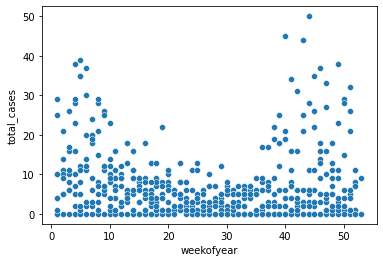

In [ ]:
sns.scatterplot(data=train_iq, x="weekofyear", y="total_cases")

### Correlación de variables y selección de caracteristicas

In [ ]:
#Creo función para pintar las celdas con valor mayor al 70% de correlación (0.7)
def text_format(val):
    if val > 0.7 or val < -0.7 :
      color = 'salmon' 
    else:
      color = 'white'
    return 'background-color: %s' % color

In [ ]:
corr_sj = train_sj.corr()
corr_iq = train_iq.corr()

Analizamos las correlaciones de forma separada para chequear si debemos elegir características diferentes para cada uno de los dos modelos que serán desarrollados.

In [ ]:
df_sj = corr_sj.style.applymap(text_format)
df_sj

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
year,1.000000,-0.059414,-0.392926,-0.496734,-0.010001,-0.074785,0.040397,0.194845,0.198551,0.026728,0.187399,0.114454,-0.128380,-0.279081,0.040397,0.029076,0.323215,-0.087018,-0.275305,-0.160795,0.007615,0.089107,-0.219769
weekofyear,-0.059414,1.000000,-0.061710,-0.037281,-0.017643,-0.083092,0.238772,0.571839,0.558422,0.572321,0.515575,0.572531,0.250419,0.300820,0.238772,0.579951,-0.094503,0.477966,-0.146604,0.314227,0.519663,0.212644,0.316289
ndvi_ne,-0.392926,-0.061710,1.000000,0.614933,0.207167,0.157215,-0.059490,-0.082892,-0.081350,-0.055332,-0.057789,-0.091884,-0.003853,0.020844,-0.059490,-0.052369,-0.018058,0.056083,0.188804,0.105071,0.002338,-0.083556,0.017544
ndvi_nw,-0.496734,-0.037281,0.614933,1.000000,0.192648,0.218702,-0.041544,-0.079048,-0.077645,-0.030207,-0.045949,-0.077541,0.002467,0.070766,-0.041544,-0.024675,-0.048016,0.087227,0.185244,0.136983,0.016611,-0.083786,0.078832
ndvi_se,-0.010001,-0.017643,0.207167,0.192648,1.000000,0.819194,-0.110768,-0.010321,-0.007550,-0.058910,-0.002131,-0.043586,-0.129914,-0.113016,-0.110768,-0.054571,0.033855,-0.054277,0.014482,-0.059996,-0.066780,-0.134086,-0.011135
ndvi_sw,-0.074785,-0.083092,0.157215,0.218702,0.819194,1.000000,-0.115826,-0.041755,-0.034396,-0.087821,-0.013221,-0.071904,-0.128357,-0.121795,-0.115826,-0.080836,0.058139,-0.041200,0.070019,-0.016506,-0.073877,-0.172584,-0.012621
precipitation_amt_mm,0.040397,0.238772,-0.059490,-0.041544,-0.110768,-0.115826,1.000000,0.239671,0.228062,0.408288,0.264121,0.250530,0.512170,0.507015,1.000000,0.415799,-0.092870,0.201182,-0.160912,0.194394,0.231584,0.569982,0.097472
reanalysis_air_temp_k,0.194845,0.571839,-0.082892,-0.079048,-0.010321,-0.041755,0.239671,1.000000,0.997550,0.905129,0.935636,0.942278,0.080717,0.303082,0.239671,0.906742,0.178911,0.880671,0.043306,0.700330,0.832637,0.120490,0.226296
reanalysis_avg_temp_k,0.198551,0.558422,-0.081350,-0.077645,-0.007550,-0.034396,0.228062,0.997550,1.000000,0.897373,0.939538,0.939261,0.063313,0.289841,0.228062,0.898500,0.201418,0.879144,0.058060,0.705968,0.826941,0.105066,0.220509
reanalysis_dew_point_temp_k,0.026728,0.572321,-0.055332,-0.030207,-0.058910,-0.087821,0.408288,0.905129,0.897373,1.000000,0.849980,0.899525,0.325311,0.679237,0.408288,0.998528,-0.027036,0.868516,-0.053440,0.693067,0.850769,0.290361,0.237267


In [ ]:
df_iq = corr_iq.style.applymap(text_format)
df_iq

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
year,1.000000,-0.135051,-0.066886,0.033040,-0.073019,-0.019687,0.086879,0.028946,0.011227,0.320727,-0.157830,0.220365,0.162762,0.254013,0.086879,0.324552,-0.235109,0.087776,-0.111953,0.016995,0.127657,-0.036338,0.218897
weekofyear,-0.135051,1.000000,0.267925,0.230738,0.336582,0.268840,-0.104434,0.282622,0.295609,-0.099666,0.397162,-0.028853,-0.150326,-0.279778,-0.104434,-0.089576,0.344776,0.079200,0.212880,0.184177,-0.096471,-0.039949,-0.074842
ndvi_ne,-0.066886,0.267925,1.000000,0.766340,0.768896,0.841026,-0.010331,0.163490,0.181214,-0.031380,0.228805,-0.007023,-0.086217,-0.141708,-0.010331,-0.029944,0.181390,0.131121,0.160545,0.151328,-0.012554,0.009524,-0.009705
ndvi_nw,0.033040,0.230738,0.766340,1.000000,0.645684,0.768827,-0.056526,0.157087,0.174525,-0.032803,0.210404,0.003274,-0.079410,-0.134980,-0.056526,-0.028336,0.172118,0.127179,0.197430,0.152238,-0.091388,-0.015504,-0.022237
ndvi_se,-0.073019,0.336582,0.768896,0.645684,1.000000,0.714007,-0.039734,0.203405,0.216252,-0.059904,0.268918,-0.023689,-0.124899,-0.192535,-0.039734,-0.057256,0.229749,0.135429,0.185128,0.163867,-0.053032,0.011017,-0.061701
ndvi_sw,-0.019687,0.268840,0.841026,0.768827,0.714007,1.000000,-0.017847,0.170845,0.186164,-0.031175,0.237737,-0.002568,-0.066138,-0.145328,-0.017847,-0.027119,0.182844,0.132621,0.190813,0.180862,-0.060879,-0.005142,-0.015818
precipitation_amt_mm,0.086879,-0.104434,-0.010331,-0.056526,-0.039734,-0.017847,1.000000,-0.046747,-0.052592,0.474499,-0.229525,0.327098,0.337098,0.431906,1.000000,0.471388,-0.378059,0.130723,-0.162512,-0.000838,0.312490,0.366948,0.111404
reanalysis_air_temp_k,0.028946,0.282622,0.163490,0.157087,0.203405,0.170845,-0.046747,1.000000,0.973483,0.148810,0.750881,0.411809,-0.086616,-0.549299,-0.046747,0.175418,0.551812,0.592679,0.503433,0.647137,0.243165,-0.134739,0.118568
reanalysis_avg_temp_k,0.011227,0.295609,0.181214,0.174525,0.216252,0.186164,-0.052592,0.973483,1.000000,0.139899,0.782391,0.396261,-0.109572,-0.541600,-0.052592,0.163665,0.601191,0.558813,0.500983,0.621062,0.214178,-0.138026,0.107292
reanalysis_dew_point_temp_k,0.320727,-0.099666,-0.031380,-0.032803,-0.059904,-0.031175,0.474499,0.148810,0.139899,1.000000,-0.259459,0.755165,0.570200,0.742263,0.474499,0.997774,-0.610510,0.339597,-0.230953,0.093841,0.620287,0.186942,0.260604


En una primera instancia podíamos pensar que las precipitaciones podían ser un factor relevante en el número de casos, sin embargo, todas las variables con contenido de precipitaciones no alcanzan casi valores superiores al 0.1 (10%) de correlación con nuestro target. 

Por tanto, procedemos a eliminar casi todas y tomaremos únicamente la columna para conjunto de datos con mayor valor de correlación que será diferente para ambos conjuntos.

In [ ]:
#TRAIN
#sj
train_sj.drop("precipitation_amt_mm", axis = 1, inplace = True)
train_sj.drop("station_precip_mm", axis = 1, inplace = True)
train_sj.drop("reanalysis_sat_precip_amt_mm", axis = 1, inplace = True)
#ij
train_iq.drop("reanalysis_precip_amt_kg_per_m2", axis = 1, inplace = True)
#train_iq.drop("precipitation_amt_mm", axis = 1, inplace = True)
train_iq.drop("station_precip_mm", axis = 1, inplace = True)
train_iq.drop("reanalysis_sat_precip_amt_mm", axis = 1, inplace = True)

#TEST
#sj
test_sj.drop("precipitation_amt_mm", axis = 1, inplace = True)
test_sj.drop("station_precip_mm", axis = 1, inplace = True)
test_sj.drop("reanalysis_sat_precip_amt_mm", axis = 1, inplace = True)
#ij
test_iq.drop("reanalysis_precip_amt_kg_per_m2", axis = 1, inplace = True)
#train_iq.drop("precipitation_amt_mm", axis = 1, inplace = True)
test_iq.drop("station_precip_mm", axis = 1, inplace = True)
test_iq.drop("reanalysis_sat_precip_amt_mm", axis = 1, inplace = True)

In [ ]:
corr_sj = train_sj.corr()
df_sj = corr_sj.style.applymap(text_format)
df_sj

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,total_cases
year,1.000000,-0.059414,-0.392926,-0.496734,-0.010001,-0.074785,0.194845,0.198551,0.026728,0.187399,0.114454,-0.128380,-0.279081,0.029076,0.323215,-0.087018,-0.275305,-0.160795,0.007615,-0.219769
weekofyear,-0.059414,1.000000,-0.061710,-0.037281,-0.017643,-0.083092,0.571839,0.558422,0.572321,0.515575,0.572531,0.250419,0.300820,0.579951,-0.094503,0.477966,-0.146604,0.314227,0.519663,0.316289
ndvi_ne,-0.392926,-0.061710,1.000000,0.614933,0.207167,0.157215,-0.082892,-0.081350,-0.055332,-0.057789,-0.091884,-0.003853,0.020844,-0.052369,-0.018058,0.056083,0.188804,0.105071,0.002338,0.017544
ndvi_nw,-0.496734,-0.037281,0.614933,1.000000,0.192648,0.218702,-0.079048,-0.077645,-0.030207,-0.045949,-0.077541,0.002467,0.070766,-0.024675,-0.048016,0.087227,0.185244,0.136983,0.016611,0.078832
ndvi_se,-0.010001,-0.017643,0.207167,0.192648,1.000000,0.819194,-0.010321,-0.007550,-0.058910,-0.002131,-0.043586,-0.129914,-0.113016,-0.054571,0.033855,-0.054277,0.014482,-0.059996,-0.066780,-0.011135
ndvi_sw,-0.074785,-0.083092,0.157215,0.218702,0.819194,1.000000,-0.041755,-0.034396,-0.087821,-0.013221,-0.071904,-0.128357,-0.121795,-0.080836,0.058139,-0.041200,0.070019,-0.016506,-0.073877,-0.012621
reanalysis_air_temp_k,0.194845,0.571839,-0.082892,-0.079048,-0.010321,-0.041755,1.000000,0.997550,0.905129,0.935636,0.942278,0.080717,0.303082,0.906742,0.178911,0.880671,0.043306,0.700330,0.832637,0.226296
reanalysis_avg_temp_k,0.198551,0.558422,-0.081350,-0.077645,-0.007550,-0.034396,0.997550,1.000000,0.897373,0.939538,0.939261,0.063313,0.289841,0.898500,0.201418,0.879144,0.058060,0.705968,0.826941,0.220509
reanalysis_dew_point_temp_k,0.026728,0.572321,-0.055332,-0.030207,-0.058910,-0.087821,0.905129,0.897373,1.000000,0.849980,0.899525,0.325311,0.679237,0.998528,-0.027036,0.868516,-0.053440,0.693067,0.850769,0.237267
reanalysis_max_air_temp_k,0.187399,0.515575,-0.057789,-0.045949,-0.002131,-0.013221,0.935636,0.939538,0.849980,1.000000,0.828613,0.093536,0.293608,0.856013,0.354812,0.852510,0.116775,0.762542,0.770509,0.232038


In [ ]:
corr_iq = train_iq.corr()
df_iq = corr_iq.style.applymap(text_format)
df_iq

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,total_cases
year,1.000000,-0.135051,-0.066886,0.033040,-0.073019,-0.019687,0.086879,0.028946,0.011227,0.320727,-0.157830,0.220365,0.254013,0.324552,-0.235109,0.087776,-0.111953,0.016995,0.127657,0.218897
weekofyear,-0.135051,1.000000,0.267925,0.230738,0.336582,0.268840,-0.104434,0.282622,0.295609,-0.099666,0.397162,-0.028853,-0.279778,-0.089576,0.344776,0.079200,0.212880,0.184177,-0.096471,-0.074842
ndvi_ne,-0.066886,0.267925,1.000000,0.766340,0.768896,0.841026,-0.010331,0.163490,0.181214,-0.031380,0.228805,-0.007023,-0.141708,-0.029944,0.181390,0.131121,0.160545,0.151328,-0.012554,-0.009705
ndvi_nw,0.033040,0.230738,0.766340,1.000000,0.645684,0.768827,-0.056526,0.157087,0.174525,-0.032803,0.210404,0.003274,-0.134980,-0.028336,0.172118,0.127179,0.197430,0.152238,-0.091388,-0.022237
ndvi_se,-0.073019,0.336582,0.768896,0.645684,1.000000,0.714007,-0.039734,0.203405,0.216252,-0.059904,0.268918,-0.023689,-0.192535,-0.057256,0.229749,0.135429,0.185128,0.163867,-0.053032,-0.061701
ndvi_sw,-0.019687,0.268840,0.841026,0.768827,0.714007,1.000000,-0.017847,0.170845,0.186164,-0.031175,0.237737,-0.002568,-0.145328,-0.027119,0.182844,0.132621,0.190813,0.180862,-0.060879,-0.015818
precipitation_amt_mm,0.086879,-0.104434,-0.010331,-0.056526,-0.039734,-0.017847,1.000000,-0.046747,-0.052592,0.474499,-0.229525,0.327098,0.431906,0.471388,-0.378059,0.130723,-0.162512,-0.000838,0.312490,0.111404
reanalysis_air_temp_k,0.028946,0.282622,0.163490,0.157087,0.203405,0.170845,-0.046747,1.000000,0.973483,0.148810,0.750881,0.411809,-0.549299,0.175418,0.551812,0.592679,0.503433,0.647137,0.243165,0.118568
reanalysis_avg_temp_k,0.011227,0.295609,0.181214,0.174525,0.216252,0.186164,-0.052592,0.973483,1.000000,0.139899,0.782391,0.396261,-0.541600,0.163665,0.601191,0.558813,0.500983,0.621062,0.214178,0.107292
reanalysis_dew_point_temp_k,0.320727,-0.099666,-0.031380,-0.032803,-0.059904,-0.031175,0.474499,0.148810,0.139899,1.000000,-0.259459,0.755165,0.742263,0.997774,-0.610510,0.339597,-0.230953,0.093841,0.620287,0.260604


Procedemos al análisis de otra variable a priori importante, LA HUMEDAD.

En este caso, solo contamos con dos variables

- reanalysis_relative_humidity_percent
- reanalysis_specific_humidity_g_per_kg

Aquí tenemos una correlación considerable en ambos conjuntos y un 26% para la segunda de las características mencionadas. Por este motivo, tomamos dicha característica y eliminamos la otra de ambos conjuntos.

In [ ]:
#TRAIN
train_sj.drop("reanalysis_relative_humidity_percent", axis = 1, inplace = True)
train_iq.drop("reanalysis_relative_humidity_percent", axis = 1, inplace = True)

#TEST
test_sj.drop("reanalysis_relative_humidity_percent", axis = 1, inplace = True)
test_iq.drop("reanalysis_relative_humidity_percent", axis = 1, inplace = True)

 Continuando con el ejercicio, analizamos la variable más importante (la mayor parte de columnas hacen referencia a ella), la TEMPERATURA. 

Dado que las variables están muy correlacionadas entre ellas, tomaremos al menos 2 para cada ciudad que presenten los valores más elevados en correlación. (Teniendo en cuenta las variables de Temperatura y Humedad)

San juan
- reanalysis_specific_humidity_g_per_kg
- station_max_temp_c

Iquitos

- reanalysis_specific_humidity_g_per_kg
- station_min_temp_c
- reanalysis_tdtr_k

In [ ]:
#TRAIN
#sj
train_sj.drop("reanalysis_air_temp_k", axis = 1, inplace = True)
train_sj.drop("reanalysis_avg_temp_k", axis = 1, inplace = True)
train_sj.drop("reanalysis_dew_point_temp_k", axis = 1, inplace = True)
train_sj.drop("reanalysis_max_air_temp_k", axis = 1, inplace = True)
train_sj.drop("reanalysis_min_air_temp_k", axis = 1, inplace = True)
train_sj.drop("station_avg_temp_c", axis = 1, inplace = True)
train_sj.drop("station_diur_temp_rng_c", axis = 1, inplace = True)
train_sj.drop("reanalysis_tdtr_k", axis = 1, inplace = True)
train_sj.drop("station_min_temp_c", axis = 1, inplace = True)

#iq
train_iq.drop("reanalysis_air_temp_k", axis = 1, inplace = True)
train_iq.drop("reanalysis_avg_temp_k", axis = 1, inplace = True)
train_iq.drop("reanalysis_dew_point_temp_k", axis = 1, inplace = True)
train_iq.drop("reanalysis_max_air_temp_k", axis = 1, inplace = True)
train_iq.drop("reanalysis_min_air_temp_k", axis = 1, inplace = True)
train_iq.drop("station_avg_temp_c", axis = 1, inplace = True)
train_iq.drop("station_diur_temp_rng_c", axis = 1, inplace = True)
train_iq.drop("station_max_temp_c", axis = 1, inplace = True)

#TEST
#sj
test_sj.drop("reanalysis_air_temp_k", axis = 1, inplace = True)
test_sj.drop("reanalysis_avg_temp_k", axis = 1, inplace = True)
test_sj.drop("reanalysis_dew_point_temp_k", axis = 1, inplace = True)
test_sj.drop("reanalysis_max_air_temp_k", axis = 1, inplace = True)
test_sj.drop("reanalysis_min_air_temp_k", axis = 1, inplace = True)
test_sj.drop("station_avg_temp_c", axis = 1, inplace = True)
test_sj.drop("station_diur_temp_rng_c", axis = 1, inplace = True)
test_sj.drop("reanalysis_tdtr_k", axis = 1, inplace = True)
test_sj.drop("station_min_temp_c", axis = 1, inplace = True)
#iq
test_iq.drop("reanalysis_air_temp_k", axis = 1, inplace = True)
test_iq.drop("reanalysis_avg_temp_k", axis = 1, inplace = True)
test_iq.drop("reanalysis_dew_point_temp_k", axis = 1, inplace = True)
test_iq.drop("reanalysis_max_air_temp_k", axis = 1, inplace = True)
test_iq.drop("reanalysis_min_air_temp_k", axis = 1, inplace = True)
test_iq.drop("station_avg_temp_c", axis = 1, inplace = True)
test_iq.drop("station_diur_temp_rng_c", axis = 1, inplace = True)
test_iq.drop("station_max_temp_c", axis = 1, inplace = True)

In [ ]:
corr_sj = train_sj.corr()
df_sj = corr_sj.style.applymap(text_format)
df_sj

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,total_cases
year,1.000000,-0.059414,-0.392926,-0.496734,-0.010001,-0.074785,-0.128380,0.029076,-0.160795,-0.219769
weekofyear,-0.059414,1.000000,-0.061710,-0.037281,-0.017643,-0.083092,0.250419,0.579951,0.314227,0.316289
ndvi_ne,-0.392926,-0.061710,1.000000,0.614933,0.207167,0.157215,-0.003853,-0.052369,0.105071,0.017544
ndvi_nw,-0.496734,-0.037281,0.614933,1.000000,0.192648,0.218702,0.002467,-0.024675,0.136983,0.078832
ndvi_se,-0.010001,-0.017643,0.207167,0.192648,1.000000,0.819194,-0.129914,-0.054571,-0.059996,-0.011135
ndvi_sw,-0.074785,-0.083092,0.157215,0.218702,0.819194,1.000000,-0.128357,-0.080836,-0.016506,-0.012621
reanalysis_precip_amt_kg_per_m2,-0.128380,0.250419,-0.003853,0.002467,-0.129914,-0.128357,1.000000,0.331426,0.081332,0.118698
reanalysis_specific_humidity_g_per_kg,0.029076,0.579951,-0.052369,-0.024675,-0.054571,-0.080836,0.331426,1.000000,0.694595,0.244332
station_max_temp_c,-0.160795,0.314227,0.105071,0.136983,-0.059996,-0.016506,0.081332,0.694595,1.000000,0.162284
total_cases,-0.219769,0.316289,0.017544,0.078832,-0.011135,-0.012621,0.118698,0.244332,0.162284,1.000000


In [ ]:
corr_iq = train_iq.corr()
df_iq = corr_iq.style.applymap(text_format)
df_iq

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_min_temp_c,total_cases
year,1.000000,-0.135051,-0.066886,0.033040,-0.073019,-0.019687,0.086879,0.324552,-0.235109,0.127657,0.218897
weekofyear,-0.135051,1.000000,0.267925,0.230738,0.336582,0.268840,-0.104434,-0.089576,0.344776,-0.096471,-0.074842
ndvi_ne,-0.066886,0.267925,1.000000,0.766340,0.768896,0.841026,-0.010331,-0.029944,0.181390,-0.012554,-0.009705
ndvi_nw,0.033040,0.230738,0.766340,1.000000,0.645684,0.768827,-0.056526,-0.028336,0.172118,-0.091388,-0.022237
ndvi_se,-0.073019,0.336582,0.768896,0.645684,1.000000,0.714007,-0.039734,-0.057256,0.229749,-0.053032,-0.061701
ndvi_sw,-0.019687,0.268840,0.841026,0.768827,0.714007,1.000000,-0.017847,-0.027119,0.182844,-0.060879,-0.015818
precipitation_amt_mm,0.086879,-0.104434,-0.010331,-0.056526,-0.039734,-0.017847,1.000000,0.471388,-0.378059,0.312490,0.111404
reanalysis_specific_humidity_g_per_kg,0.324552,-0.089576,-0.029944,-0.028336,-0.057256,-0.027119,0.471388,1.000000,-0.596522,0.617684,0.268597
reanalysis_tdtr_k,-0.235109,0.344776,0.181390,0.172118,0.229749,0.182844,-0.378059,-0.596522,1.000000,-0.342356,-0.137113
station_min_temp_c,0.127657,-0.096471,-0.012554,-0.091388,-0.053032,-0.060879,0.312490,0.617684,-0.342356,1.000000,0.208815


Continuando con el ejercicio procederemos a analizar la variable LOCALIZACION.

Para este análisis tendremos en cuenta las siguientes columnas:

- ndvi_ne 
- ndvi_nw 
- ndvi_se 
- ndvi_sw 

Teniendo en cuenta que la variable city sale del ejercicio ya que contamos con dataset separados para cada ciudad.


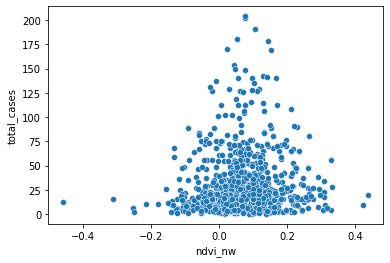

In [ ]:
sns.scatterplot(data=train_sj, x="ndvi_nw", y="total_cases")

Observando la distribución de puntos crearemos una zona 0 para aquellos valores menores a -0.1 y mayores a 0.3, una zona 1 para aquellos valores inferiores a -0.1 a 0.05 y de 0.2 a 0.3 y una zona 2 para los valores de 0.05 a 0.2

In [ ]:
def get_RegionSJ(row):
  region = None
  if row[3] < -0.1 or row[3]>0.3:
    region = 0
  
  elif (row[3]>= -0.1 and row[3]<= 0.05) or (row[3]>= 0.2 and row[3]<=0.3):
    region = 1
  
  else:
    region = 2

  return region

In [ ]:
train_sj['Region']=train_sj.apply(lambda row: get_RegionSJ(row), axis=1)
test_sj['Region']=test_sj.apply(lambda row: get_RegionSJ(row), axis=1)

In [ ]:
corr_sj = train_sj.corr()
df_sj = corr_sj.style.applymap(text_format)
df_sj

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,total_cases,Region
year,1.000000,-0.059414,-0.392926,-0.496734,-0.010001,-0.074785,-0.128380,0.029076,-0.160795,-0.219769,-0.346005
weekofyear,-0.059414,1.000000,-0.061710,-0.037281,-0.017643,-0.083092,0.250419,0.579951,0.314227,0.316289,0.059872
ndvi_ne,-0.392926,-0.061710,1.000000,0.614933,0.207167,0.157215,-0.003853,-0.052369,0.105071,0.017544,0.250310
ndvi_nw,-0.496734,-0.037281,0.614933,1.000000,0.192648,0.218702,0.002467,-0.024675,0.136983,0.078832,0.440845
ndvi_se,-0.010001,-0.017643,0.207167,0.192648,1.000000,0.819194,-0.129914,-0.054571,-0.059996,-0.011135,-0.076355
ndvi_sw,-0.074785,-0.083092,0.157215,0.218702,0.819194,1.000000,-0.128357,-0.080836,-0.016506,-0.012621,-0.042748
reanalysis_precip_amt_kg_per_m2,-0.128380,0.250419,-0.003853,0.002467,-0.129914,-0.128357,1.000000,0.331426,0.081332,0.118698,0.111602
reanalysis_specific_humidity_g_per_kg,0.029076,0.579951,-0.052369,-0.024675,-0.054571,-0.080836,0.331426,1.000000,0.694595,0.244332,0.131601
station_max_temp_c,-0.160795,0.314227,0.105071,0.136983,-0.059996,-0.016506,0.081332,0.694595,1.000000,0.162284,0.181472
total_cases,-0.219769,0.316289,0.017544,0.078832,-0.011135,-0.012621,0.118698,0.244332,0.162284,1.000000,0.124849


Obtenemos una variable con feature engineering que consigue un 12% de correlación unificando y superando a todas las variables de las que disponiamos para el conjunto de datos de San Juan.

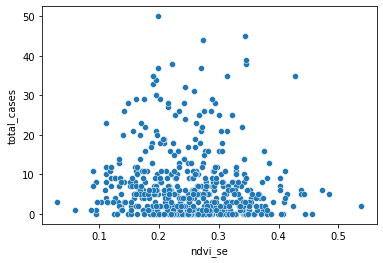

In [ ]:
sns.scatterplot(data=train_iq, x="ndvi_se", y="total_cases")

In [ ]:
def get_RegionIQ(row):
  region = None
  if row[4] < 0.2 or row[3]>0.3:
    region = 1  
  else:
    region = 2

  return region

In [ ]:
train_iq['Region']=train_iq.apply(lambda row: get_RegionSJ(row), axis=1)

In [ ]:
corr_iq = train_iq.corr()
df_iq = corr_iq.style.applymap(text_format)
df_iq

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_min_temp_c,total_cases,Region
year,1.000000,-0.135051,-0.066886,0.033040,-0.073019,-0.019687,0.086879,0.324552,-0.235109,0.127657,0.218897,-0.000390
weekofyear,-0.135051,1.000000,0.267925,0.230738,0.336582,0.268840,-0.104434,-0.089576,0.344776,-0.096471,-0.074842,-0.227154
ndvi_ne,-0.066886,0.267925,1.000000,0.766340,0.768896,0.841026,-0.010331,-0.029944,0.181390,-0.012554,-0.009705,-0.718379
ndvi_nw,0.033040,0.230738,0.766340,1.000000,0.645684,0.768827,-0.056526,-0.028336,0.172118,-0.091388,-0.022237,-0.907531
ndvi_se,-0.073019,0.336582,0.768896,0.645684,1.000000,0.714007,-0.039734,-0.057256,0.229749,-0.053032,-0.061701,-0.597114
ndvi_sw,-0.019687,0.268840,0.841026,0.768827,0.714007,1.000000,-0.017847,-0.027119,0.182844,-0.060879,-0.015818,-0.711091
precipitation_amt_mm,0.086879,-0.104434,-0.010331,-0.056526,-0.039734,-0.017847,1.000000,0.471388,-0.378059,0.312490,0.111404,0.037062
reanalysis_specific_humidity_g_per_kg,0.324552,-0.089576,-0.029944,-0.028336,-0.057256,-0.027119,0.471388,1.000000,-0.596522,0.617684,0.268597,0.032880
reanalysis_tdtr_k,-0.235109,0.344776,0.181390,0.172118,0.229749,0.182844,-0.378059,-0.596522,1.000000,-0.342356,-0.137113,-0.182670
station_min_temp_c,0.127657,-0.096471,-0.012554,-0.091388,-0.053032,-0.060879,0.312490,0.617684,-0.342356,1.000000,0.208815,0.075488


En este conjunto de datos no conseguimos una variable que se considere favorable para el modelo y se eliminaran todas las variables que hacen referencia a la localización.

In [ ]:
#TRAIN
#sj
train_sj.drop("ndvi_ne", axis = 1, inplace = True)
train_sj.drop("ndvi_nw", axis = 1, inplace = True)
train_sj.drop("ndvi_se", axis = 1, inplace = True)
train_sj.drop("ndvi_sw", axis = 1, inplace = True)
#iq
train_iq.drop("ndvi_ne", axis = 1, inplace = True)
train_iq.drop("ndvi_nw", axis = 1, inplace = True)
train_iq.drop("ndvi_se", axis = 1, inplace = True)
train_iq.drop("ndvi_sw", axis = 1, inplace = True)
train_iq.drop("Region", axis = 1, inplace = True)

#TEST
#sj
test_sj.drop("ndvi_ne", axis = 1, inplace = True)
test_sj.drop("ndvi_nw", axis = 1, inplace = True)
test_sj.drop("ndvi_se", axis = 1, inplace = True)
test_sj.drop("ndvi_sw", axis = 1, inplace = True)
#iq
test_iq.drop("ndvi_ne", axis = 1, inplace = True)
test_iq.drop("ndvi_nw", axis = 1, inplace = True)
test_iq.drop("ndvi_se", axis = 1, inplace = True)
test_iq.drop("ndvi_sw", axis = 1, inplace = True)


In [ ]:
corr_sj = train_sj.corr()
df_sj = corr_sj.style.applymap(text_format)
df_sj

,year,weekofyear,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,total_cases,Region
year,1.000000,-0.059414,-0.128380,0.029076,-0.160795,-0.219769,-0.346005
weekofyear,-0.059414,1.000000,0.250419,0.579951,0.314227,0.316289,0.059872
reanalysis_precip_amt_kg_per_m2,-0.128380,0.250419,1.000000,0.331426,0.081332,0.118698,0.111602
reanalysis_specific_humidity_g_per_kg,0.029076,0.579951,0.331426,1.000000,0.694595,0.244332,0.131601
station_max_temp_c,-0.160795,0.314227,0.081332,0.694595,1.000000,0.162284,0.181472
total_cases,-0.219769,0.316289,0.118698,0.244332,0.162284,1.000000,0.124849
Region,-0.346005,0.059872,0.111602,0.131601,0.181472,0.124849,1.000000


In [ ]:
corr_iq = train_iq.corr()
df_iq = corr_iq.style.applymap(text_format)
df_iq

,year,weekofyear,precipitation_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_min_temp_c,total_cases
year,1.000000,-0.135051,0.086879,0.324552,-0.235109,0.127657,0.218897
weekofyear,-0.135051,1.000000,-0.104434,-0.089576,0.344776,-0.096471,-0.074842
precipitation_amt_mm,0.086879,-0.104434,1.000000,0.471388,-0.378059,0.312490,0.111404
reanalysis_specific_humidity_g_per_kg,0.324552,-0.089576,0.471388,1.000000,-0.596522,0.617684,0.268597
reanalysis_tdtr_k,-0.235109,0.344776,-0.378059,-0.596522,1.000000,-0.342356,-0.137113
station_min_temp_c,0.127657,-0.096471,0.312490,0.617684,-0.342356,1.000000,0.208815
total_cases,0.218897,-0.074842,0.111404,0.268597,-0.137113,0.208815,1.000000


El siguiente análisis se corresponde con el análisis de la variable TIEMPO. 

El conjunto de datos posee dos variables que hacen referencia a esto, y dado que ambas están relacionadas con la variable objetivo será interesante su estudio. Estas variables son las siguientes:

- year
- weekofyear

De la práctica 1, conocemos que el dataset posee 20 años. 

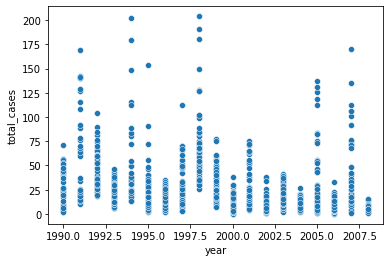

In [ ]:
sns.scatterplot(data=train_sj, x="year", y="total_cases")

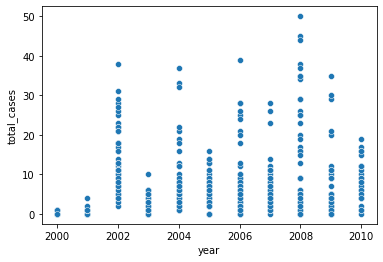

In [ ]:
sns.scatterplot(data=train_iq, x="year", y="total_cases")

No parece que exista tendencia alguna en cuanto al paso de los años, analizaremos si existe alguna tendencia en función de las semanas.

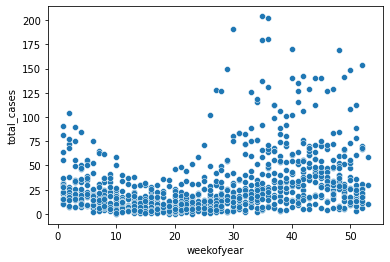

In [ ]:
sns.scatterplot(data=train_sj, x="weekofyear", y="total_cases")

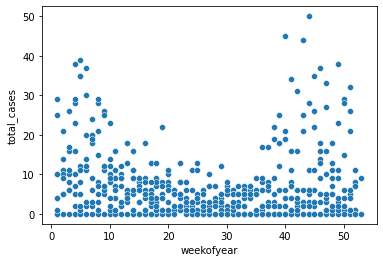

In [ ]:
sns.scatterplot(data=train_iq, x="weekofyear", y="total_cases")

Aunque el clima de estas ciudades es tropical y no existe prácticamente diferencia durante el año, analizaremos si estas leves variaciones de temperatura afectan al número de casos.

Según los gráficos, y teniendo en cuenta que el invierno en San Juan se corresponde con las semanas 52-53 y de la 1 a 10, no parece que existan patrones en cuanto a estacionalidad.

Sin embargo, en iquitos, parece que durante las semanas 26 a 37 que se corresponden con el invierno si se observa una reducción de casos.

In [ ]:
#Damos valor 1 al invierno y 2 al resto de estaciones en Iquitos
train_iq['Estacion'] = train_iq.apply(lambda row: 1 if (row[1]>=26 and row[1]<=37) else  2,axis=1)
test_iq['Estacion'] = test_iq.apply(lambda row: 1 if (row[1]>=26 and row[1]<=37) else  2,axis=1)

In [ ]:
corr_iq = train_iq.corr()
df_iq = corr_iq.style.applymap(text_format)
df_iq

,year,weekofyear,precipitation_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_min_temp_c,total_cases,Estacion
year,1.000000,-0.135051,0.086879,0.324552,-0.235109,0.127657,0.218897,0.092796
weekofyear,-0.135051,1.000000,-0.104434,-0.089576,0.344776,-0.096471,-0.074842,-0.186601
precipitation_amt_mm,0.086879,-0.104434,1.000000,0.471388,-0.378059,0.312490,0.111404,0.335892
reanalysis_specific_humidity_g_per_kg,0.324552,-0.089576,0.471388,1.000000,-0.596522,0.617684,0.268597,0.596043
reanalysis_tdtr_k,-0.235109,0.344776,-0.378059,-0.596522,1.000000,-0.342356,-0.137113,-0.405002
station_min_temp_c,0.127657,-0.096471,0.312490,0.617684,-0.342356,1.000000,0.208815,0.460382
total_cases,0.218897,-0.074842,0.111404,0.268597,-0.137113,0.208815,1.000000,0.244832
Estacion,0.092796,-0.186601,0.335892,0.596043,-0.405002,0.460382,0.244832,1.000000


Con el resultado obtenido, parece que la Estación puede ser un factor a tener en cuenta en Iquitos.

Procedemos a eliminar el resto de columnas en ambos conjuntos de datos.

In [ ]:
"""
#TRAIN
#sj
train_sj.drop("year", axis = 1, inplace = True)
train_sj.drop("weekofyear", axis = 1, inplace = True)
#iq
train_iq.drop("year", axis = 1, inplace = True)
train_iq.drop("weekofyear", axis = 1, inplace = True)

#TEST
#sj
test_sj.drop("year", axis = 1, inplace = True)
test_sj.drop("weekofyear", axis = 1, inplace = True)
#iq
test_iq.drop("year", axis = 1, inplace = True)
test_iq.drop("weekofyear", axis = 1, inplace = True)
"""

'\n#TRAIN\n#sj\ntrain_sj.drop("year", axis = 1, inplace = True)\ntrain_sj.drop("weekofyear", axis = 1, inplace = True)\n#iq\ntrain_iq.drop("year", axis = 1, inplace = True)\ntrain_iq.drop("weekofyear", axis = 1, inplace = True)\n\n#TEST\n#sj\ntest_sj.drop("year", axis = 1, inplace = True)\ntest_sj.drop("weekofyear", axis = 1, inplace = True)\n#iq\ntest_iq.drop("year", axis = 1, inplace = True)\ntest_iq.drop("weekofyear", axis = 1, inplace = True)\n'

In [ ]:
corr_sj = train_sj.corr()
df_sj = corr_sj.style.applymap(text_format)
df_sj

,year,weekofyear,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,total_cases,Region
year,1.000000,-0.059414,-0.128380,0.029076,-0.160795,-0.219769,-0.346005
weekofyear,-0.059414,1.000000,0.250419,0.579951,0.314227,0.316289,0.059872
reanalysis_precip_amt_kg_per_m2,-0.128380,0.250419,1.000000,0.331426,0.081332,0.118698,0.111602
reanalysis_specific_humidity_g_per_kg,0.029076,0.579951,0.331426,1.000000,0.694595,0.244332,0.131601
station_max_temp_c,-0.160795,0.314227,0.081332,0.694595,1.000000,0.162284,0.181472
total_cases,-0.219769,0.316289,0.118698,0.244332,0.162284,1.000000,0.124849
Region,-0.346005,0.059872,0.111602,0.131601,0.181472,0.124849,1.000000


In [ ]:
corr_iq = train_iq.corr()
df_iq = corr_iq.style.applymap(text_format)
df_iq

,year,weekofyear,precipitation_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_min_temp_c,total_cases,Estacion
year,1.000000,-0.135051,0.086879,0.324552,-0.235109,0.127657,0.218897,0.092796
weekofyear,-0.135051,1.000000,-0.104434,-0.089576,0.344776,-0.096471,-0.074842,-0.186601
precipitation_amt_mm,0.086879,-0.104434,1.000000,0.471388,-0.378059,0.312490,0.111404,0.335892
reanalysis_specific_humidity_g_per_kg,0.324552,-0.089576,0.471388,1.000000,-0.596522,0.617684,0.268597,0.596043
reanalysis_tdtr_k,-0.235109,0.344776,-0.378059,-0.596522,1.000000,-0.342356,-0.137113,-0.405002
station_min_temp_c,0.127657,-0.096471,0.312490,0.617684,-0.342356,1.000000,0.208815,0.460382
total_cases,0.218897,-0.074842,0.111404,0.268597,-0.137113,0.208815,1.000000,0.244832
Estacion,0.092796,-0.186601,0.335892,0.596043,-0.405002,0.460382,0.244832,1.000000


## MODELOS SUPERVISADOS

#### Normalizacion de los datos

In [ ]:
selected_features_sj = ['reanalysis_precip_amt_kg_per_m2','reanalysis_specific_humidity_g_per_kg','station_max_temp_c','Region']
selected_features_iq = ['precipitation_amt_mm','reanalysis_specific_humidity_g_per_kg','reanalysis_tdtr_k','station_min_temp_c','Estacion']

In [ ]:
from sklearn import preprocessing
#scaler1 = preprocessing.StandardScaler()
scaler1 = preprocessing.MinMaxScaler()

In [ ]:
#SJ
X_train_scaled_sj = scaler1.fit_transform(train_sj[selected_features_sj])
X_test_scaled_sj = scaler1.transform(test_sj[selected_features_sj])


In [ ]:
from sklearn import preprocessing
#scaler2 = preprocessing.StandardScaler()
scaler2 = preprocessing.MinMaxScaler()

In [ ]:
#IQ
X_train_scaled_iq = scaler2.fit_transform(train_iq[selected_features_iq])
X_test_scaled_iq = scaler2.transform(test_iq[selected_features_iq])

In [ ]:
y_train_sj = train_sj['total_cases'].to_numpy()
y_train_iq = train_iq['total_cases'].to_numpy()

#### Desarrollo de modelos

Se construyen los dos modelos de forma individual, se genera de ambos casos un array, se concatena con el mismo orden (1:sj , 2:iq) y se construye el output para ser evaluado.

Se realizará Cross Validation y por tanto no crearemos conjunto de validación.

##### SAN JUAN

In [ ]:
# ENFOQUE CON BOOSTING
#Importamos las librerias correspondientes
from sklearn import linear_model
from numpy import absolute
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


X_sj, X_sj_test, y_sj, y_sj_test = train_test_split(X_train_scaled_sj, y_train_sj, test_size=0.2, random_state=42)

model = XGBRegressor()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_sj, y_sj, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
model.fit(X_train_scaled_sj,y_train_sj)

"""
#MODELO INICIAL
model = linear_model.LinearRegression()
model.fit(X_train_sj,y_train_sj)
"""


Mean MAE: 21.152 (1.730)
[11:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


'\n#MODELO INICIAL\nmodel = linear_model.LinearRegression()\nmodel.fit(X_train_sj,y_train_sj)\n'

In [ ]:
"""
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestRegressor()

#Hiperparametros
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 110, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
#Construimos Grid 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#Construimos modelo tras busqueda
model = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#Ajustamos a los datos de train
model.fit(X_sj, y_sj)

"""

Fitting 3 folds for each of 200 candidates, totalling 600 fits


"\ncv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)\nscores = cross_val_score(model, X_sj, y_sj, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)\nscores = absolute(scores)\nprint('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )\nmodel.fit(X_train_scaled_sj,y_train_sj)\n"

In [ ]:
model.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

Una vez construido nuestro modelo, procedemos a su evaluación

In [ ]:
y_pred_sj = model.predict(X_sj_test)
y_pred_sj = np.rint(y_pred_sj)
y_pred_sj = y_pred_sj.astype(int)
y_pred_sj

array([ 48,  35,  23,  24,  19,  21,  28,  18,  39,  30,  23,  19,  26,
        23,  37,  20,  18,  28,  19,  16,  37, 168,  32,  23,  25,  22,
        27,  29,  42,  35,  32,  43,  32,  22,  25,  21,  38,  28,  28,
        16,  36,  25,  31,  39,  47,  26,  35,  22,  19,  31,  18,  28,
        20,  45,  13,  16,  42,  19,  16,  12,  28,  24,  16,  24,  34,
        33,  19,  22,  35,  22,  21,  31,  31,  17,  26,  62,  28,  26,
        29,  25,  17,  22,  17,  29,  23,  19,  13,  30,  35,  27,  37,
        33,  42,  23,  19,  18,  25,  29,  51,  16,  21,  41,  33,  37,
        15,  19,  70,  23,  40,  18,  21,  36,  22,  14,  27,  15,  17,
        18,  22,  14,  17,  25,  29,  18,  18,  22,  36,  18,  22,  15,
        23,  41,  14,  42,  33,  42,  25,  27,  40,  36,  30,  24,  35,
        20,  22,  23,  21,  21,  23,  25,  21,  25,  14,  32,  26,  24,
        38,  37,  18,  24,  30,  29,  41,  15,  34,  62,  22,  19,  27,
       120,  23,  37,  21,  22,  18,  33,  32,  32,  28,  29,  3

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_sj_test, np.rint(y_pred_sj))

16.619565217391305

In [ ]:
y_sj_test

array([ 89,  52,  11,  13,   6,  30,  13,  14,  37,  25,  20,  20,  14,
        23,  18,   8,  37,  51,   7,  16,  12, 204,   4,  17,  53,  13,
         6,  37, 202,  23,   7,  21,   6,  18,   4,  36,  68,  53,  11,
        19,   6,   6,  42,  70,  64,  10,  33,   8,  20,  25,   8,  50,
        11,  60,   5,   3,  34,   8,   6,   4,  10,  16,   3,  17,  36,
        72,   8,  28,  23,  13,  21,   7,  20,  17,  12,  55,  30,  10,
        22,  22,   2,   2,   7,   8,   8,  23,   4,  18,  11,  13,   3,
        20,  62,  26,  27,  59,  26,  91,  75,   3,  18,  28,  25,  16,
        13,   6, 142,  30,   6,  29,  11,  46,  15,  10,   6,  12,   5,
        31,  15,   5,   6,  48,  18,  16,   2,  18,  67,   6,   3,  13,
        42, 140,   6,  48,  85,  30,  38,   3, 112,  25,  17,   4,  30,
        16,  18,   5,  17,  15,  11,   4,  31,  15,   3,  14,  10,  26,
        52,  39,   2,  14,   3,  19, 129,   0,  31, 169,   4,  24,  77,
       181,  13,  30,  41,   2,  17,  40,  25,  29,  49,  40,  3

##### IQUITOS

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVR

X_iq, X_iq_test, y_iq, y_iq_test = train_test_split(X_train_scaled_iq, y_train_iq, test_size=0.2, random_state=42)

X = X_iq
y = y_iq
scores = []
best_svr = SVR(kernel='rbf')
cv = KFold(n_splits=5, random_state=42,shuffle=True)
for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    best_svr.fit(X_train, y_train)
    scores.append(best_svr.score(X_test, y_test))



In [ ]:
model_iq = best_svr

In [ ]:
y_pred_iq = model_iq.predict(X_iq_test)
y_pred_iq = np.rint(y_pred_iq)
y_pred_iq = y_pred_iq.astype(int)
y_pred_iq

array([1, 8, 4, 5, 7, 6, 3, 6, 6, 7, 7, 5, 6, 5, 3, 3, 6, 2, 7, 7, 3, 2,
       6, 2, 6, 6, 7, 7, 3, 3, 5, 7, 6, 3, 6, 5, 7, 4, 5, 6, 6, 5, 2, 2,
       3, 5, 7, 3, 2, 3, 5, 5, 7, 2, 6, 5, 2, 5, 4, 6, 7, 6, 5, 5, 7, 3,
       4, 3, 6, 2, 3, 6, 3, 3, 6, 4, 2, 6, 4, 3, 5, 6, 6, 5, 4, 2, 4, 1,
       5, 3, 5, 6, 5, 6, 5, 1, 3, 5, 4, 1, 4, 7, 6, 3])

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_iq_test, y_pred_iq)

5.1923076923076925

##### UNIFICACION Y CREACION DE OUTPUT

In [ ]:
test = pd.read_csv("/content/dengue_features_test.csv")

In [ ]:
#TEST SJ
y_pred = model.predict(X_test_scaled_sj)
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0
y_pred_no_neg

array([ 25,  25,  25,  11,  20,  30,  23,  16,  29,  30,  24,  22,  23,
        31,  40,  34,  29,  47,  43,  31,  36,  40,  38,  33,  31,  34,
        25,  37,  34,  27,  24,  19,  19,  27,  23,  24,  19,  21,  23,
        26,  23,  18,  16,  18,  18,  15,  22,  18,  20,  19,  16,  18,
        19,  22,  27,  22,  36,  27,  29,  31,  26,  24,  48,  38,  42,
        48,  30,  38,  28,  40,  17,  37,  27,  46,  36,  37,  40,  20,
        29,   9,  23,  29,  41,  23,  32,  30,  21,  21,  27,  26,  30,
        19,  20,  17,  15,  52,  26,  22,  14,  30,  25,  16,  23,  26,
        63,  32,  25,  28,  38, 109,  45,  39,  37,  56,  61,  94,  76,
        65,  45,  42,  81, 100, 122,  52,  72,  39,  36,  64,  54,  41,
        20,  33,  50,  25,  22,  22,  23,  19,  20,  21,  17,  21,  23,
        21,  18,  19,  17,  21,  22,  18,  18,  20,  24,  21,  18,  24,
        10,  28,  18,  35,  42,  37,  34, 154,  47,  58,  39,  36,  46,
        52,  62,  51,  32, 122,  38,  35,  47,  29,  35,  61,  5

In [ ]:
y_pred2 = model_iq.predict(X_test_scaled_iq)
import numpy as np
y2 = np.rint(y_pred2) # round
y2 = y2.astype(int) # cast to int
res2 = np.hstack(y2)
y_pred_no_neg2 = res2.copy()
y_pred_no_neg2[y_pred2 < 0] = 0
y_pred_no_neg2

array([3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 4, 6, 7, 4, 5, 7,
       5, 6, 6, 3, 6, 4, 5, 5, 2, 4, 5, 6, 6, 6, 5, 5, 6, 7, 6, 6, 6, 6,
       7, 3, 5, 4, 5, 4, 4, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 5,
       4, 5, 7, 5, 5, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 4, 6, 7, 5, 3, 3,
       5, 4, 3, 5, 5, 6, 7, 6, 5, 2, 5, 3, 4, 4, 1, 3, 3, 2, 2, 2, 2, 2,
       3, 3, 2, 3, 3, 3, 2, 2, 1, 5, 4, 6, 5, 5, 7, 8, 8, 6, 6, 7, 7, 4,
       5, 6, 6, 6, 6, 7, 6, 6, 7, 8, 6, 5, 5, 7, 6, 2, 6, 6, 5, 5, 4, 3,
       2, 3])

In [ ]:
y_out = np.append(y_pred_no_neg,y_pred_no_neg2)
y_out

array([ 25,  25,  25,  11,  20,  30,  23,  16,  29,  30,  24,  22,  23,
        31,  40,  34,  29,  47,  43,  31,  36,  40,  38,  33,  31,  34,
        25,  37,  34,  27,  24,  19,  19,  27,  23,  24,  19,  21,  23,
        26,  23,  18,  16,  18,  18,  15,  22,  18,  20,  19,  16,  18,
        19,  22,  27,  22,  36,  27,  29,  31,  26,  24,  48,  38,  42,
        48,  30,  38,  28,  40,  17,  37,  27,  46,  36,  37,  40,  20,
        29,   9,  23,  29,  41,  23,  32,  30,  21,  21,  27,  26,  30,
        19,  20,  17,  15,  52,  26,  22,  14,  30,  25,  16,  23,  26,
        63,  32,  25,  28,  38, 109,  45,  39,  37,  56,  61,  94,  76,
        65,  45,  42,  81, 100, 122,  52,  72,  39,  36,  64,  54,  41,
        20,  33,  50,  25,  22,  22,  23,  19,  20,  21,  17,  21,  23,
        21,  18,  19,  17,  21,  22,  18,  18,  20,  24,  21,  18,  24,
        10,  28,  18,  35,  42,  37,  34, 154,  47,  58,  39,  36,  46,
        52,  62,  51,  32, 122,  38,  35,  47,  29,  35,  61,  5

In [ ]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': y_out})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)

## CONCLUSIONES

En la presente práctica se ha generado un modelo de machine learning aplicado a regresión, en concreto, al número de casos de Dengue. 

El resultado obtenido es de 25.6 en MAE, utilizando técnicas como RandomSearchCV para una búsqueda de hiperparámetros óptima (búsqueda gruesa) que posteriormente podría ser limada con GridSearchCV. 

Sin embargo, tras haber aplicado en primera instancia modelos lineales, y tras esto, modelos de mayor complejidad como XGBoost, SVMs y RandomForest consideramos que para mejorar el resultado obtenido más alla de ligeras decimas debemos realizar más iteraciones al proceso completo experimentando con nuevos análisis en preprocesado, outliers y feature engineering.